# Deduplication Example

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Load Dataset

We'll use the [Music Brainz 20K from Database Group Leipzig](https://dbs.uni-leipzig.de/research/projects/object_matching/benchmark_datasets_for_entity_resolution). From the site: "The Music Brainz dataset is based on real records about songs from the MusicBrainz database but uses the DAPO data generator to create duplicates with modified attribute values. The generated dataset consists of five sources and contains duplicates for 50% of the original records in two to five sources. All duplicates are generated with a high degree of corruption to stress-test the ER and clustering approaches."

Here is it's [README](https://www.informatik.uni-leipzig.de/~saeedi/musicBrainz_readme.txt):

```
5 sources
---------- 
TID: a unique record's id (in the complete dataset).
CID: cluster id (records having the same CID are duplicate)
CTID: a unique id within a cluster (if two records belong to the same cluster they will have the same CID but different CTIDs). These ids (CTID) start with 1 and grow until cluster size.
SourceID: identifies to which source a record belongs (there are five sources). The sources are deduplicated.
Id: the original id from the source. Each source has its own Id-Format. Uniqueness is not guaranteed!! (can be ignored).
number: track or song number in the album.
length: the length of the track.
artist: the interpreter (artist or band) of the track.
year: date of publication.
language: language of the track.
```

Let's download the CSV dataset to a temporary directory:

In [6]:
import urllib
import tempfile

dataset_url = 'https://www.informatik.uni-leipzig.de/~saeedi/musicbrainz-20-A01.csv.dapo'
tf = tempfile.NamedTemporaryFile(mode='r', delete=False)
tf.close()

urllib.request.urlretrieve(dataset_url, tf.name);

Now we must read the CSV dataset into a `dict` called `record_dict`.

`record_dict` will contain all records from the dataset, and each record will have the indication of the true cluster it belongs to in the field `CID`.

So `CID` is our `cluster_field`. Entity Embed needs that to train, validate, and test.

We'll dynamically attribute an `id` to each record using `enumerate`. Entity Embed needs that too.

In [7]:
import csv

record_dict = {}
cluster_field = 'CID'

with open(tf.name, newline='') as f:
    for current_record_id, record in enumerate(csv.DictReader(f)):
        record['id'] = current_record_id
        record[cluster_field] = int(record[cluster_field])  # convert cluster_field to int
        record_dict[current_record_id] = record

Here's an example of a record:

In [8]:
record_dict[83]

{'TID': '84',
 'CID': 9369,
 'CTID': '4',
 'SourceID': '4',
 'id': 83,
 'number': '1',
 'title': '001-Berimbou',
 'length': '2m 23sec',
 'artist': 'Astrud Gilberto',
 'album': 'Look to the Rainbow (2008)',
 'year': 'null',
 'language': ' Eng.'}

That's a great song, but it's actually called "Berimbau", not "Berimbou"! And it's a Brazilian song, in Portuguese. This a small example on how noisy is this dataset...

How many clusters this dataset has?

In [9]:
cluster_total = len(set(record[cluster_field] for record in record_dict.values()))
cluster_total

10000

From all clusters, we'll use only 20% for training, and other 20% for validation to test how well we can generalize:

In [10]:
from entity_embed.data_utils import utils

train_record_dict, valid_record_dict, test_record_dict = utils.split_record_dict_on_clusters(
    record_dict=record_dict,
    cluster_field=cluster_field,
    train_proportion=0.2,
    valid_proportion=0.2,
    random_seed=random_seed)

12:57:25 INFO:Singleton cluster sizes (train, valid, test):(1000, 1000, 3000)
12:57:25 INFO:Plural cluster sizes (train, valid, test):(1000, 1000, 3000)


Note we're splitting the data on **clusters**, not records, so the record counts vary:

In [11]:
len(train_record_dict), len(valid_record_dict), len(test_record_dict)

(3845, 3876, 11654)

Clean up the temporary files:

In [12]:
import os

os.remove(tf.name)

## Preprocessing

We'll perform a very minimal preprocessing of the dataset. We want to simply force ASCII chars, lowercase all chars, and strip leading and trailing whitespace.

The fields we'll clean are the ones we'll use:

In [13]:
field_list = ['number', 'title', 'artist', 'album', 'year', 'language']

In [14]:
import unidecode

def clean_str(s):
    return unidecode.unidecode(s).lower().strip()

for record in record_dict.values():
    for field in field_list:
        record[field] = clean_str(record[field])

In [15]:
utils.subdict(record_dict[83], field_list)

{'number': '1',
 'title': '001-berimbou',
 'artist': 'astrud gilberto',
 'album': 'look to the rainbow (2008)',
 'year': 'null',
 'language': 'eng.'}

Forcing ASCII chars in this dataset is useful to improve recall because there's little difference between accented and not-accented chars here. Also, this dataset contains mostly latin chars.

## Configure Entity Embed fields

Now we will define how record fields will be numericalized and encoded by the neural network. First we set an `alphabet`, here we'll use ASCII numbers, letters, symbols and space:

In [16]:
from entity_embed.data_utils.field_config_parser import DEFAULT_ALPHABET

alphabet = DEFAULT_ALPHABET
''.join(alphabet)

'0123456789abcdefghijklmnopqrstuvwxyz!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ '

It's worth noting you can use any alphabet you need, so the accent removal we performed is optional.

Then we set an `field_config_dict`. It defines `field_type`s that determine how fields are processed in the neural network:

In [17]:
field_config_dict = {
    'number': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'title': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'title_semantic': {
        'key': 'title',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'artist': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'album': {
        'field_type': "MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'album_semantic': {
        'key': 'album',
        'field_type': "SEMANTIC_MULTITOKEN",
        'tokenizer': "entity_embed.default_tokenizer",
        'vocab': "fasttext.en.300d",
    },
    'year': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
    'language': {
        'field_type': "STRING",
        'alphabet': alphabet,
        'max_str_len': None,  # compute
    },
}

Then we use our `field_config_dict` to get a `record_numericalizer`. This object will convert the strings from our records into tensors for the neural network.

The same `record_numericalizer` must be used on ALL data: train, valid, test. This ensures numericalization will be consistent. Therefore, we pass `record_list=record_dict.values()`:

In [18]:
from entity_embed import FieldConfigDictParser

record_numericalizer = FieldConfigDictParser.from_dict(field_config_dict, record_list=record_dict.values())

12:57:25 INFO:For field=number, computing actual max_str_len
12:57:25 INFO:For field=number, using actual_max_str_len=56
12:57:25 INFO:For field=title, computing actual max_str_len
12:57:26 INFO:For field=title, using actual_max_str_len=38
12:57:26 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
12:57:29 INFO:For field=artist, computing actual max_str_len
12:57:29 INFO:actual_max_str_len=31 must be even to enable NN pooling. Updating to 32
12:57:29 INFO:For field=artist, using actual_max_str_len=32
12:57:29 INFO:For field=album, computing actual max_str_len
12:57:29 INFO:For field=album, using actual_max_str_len=40
12:57:29 INFO:Loading vectors from .vector_cache/wiki.en.vec.pt
12:57:33 INFO:For field=year, computing actual max_str_len
12:57:33 INFO:For field=year, using actual_max_str_len=68
12:57:33 INFO:For field=language, computing actual max_str_len
12:57:33 INFO:For field=language, using actual_max_str_len=72


## Initialize Data Module

under the hood, Entity Embed uses [pytorch-lightning](https://pytorch-lightning.readthedocs.io/en/latest/), so we need to create a datamodule object:

In [19]:
from entity_embed import DeduplicationDataModule

batch_size = 32
eval_batch_size = 64
datamodule = DeduplicationDataModule(
    train_record_dict=train_record_dict,
    valid_record_dict=valid_record_dict,
    test_record_dict=test_record_dict,
    cluster_field=cluster_field,
    record_numericalizer=record_numericalizer,
    batch_size=batch_size,
    eval_batch_size=eval_batch_size,
    random_seed=random_seed
)

We've used `DeduplicationDataModule` because we're doing Deduplication of a single dataset/table (a.k.a. Entity Clustering, Entity Resolution, etc.).

We're NOT doing Record Linkage of two datasets here. Check the other notebook [Record-Linkage-Example](Record-Linkage-Example.ipynb) if you want to learn how to do it with Entity Embed.

## Training

Now the training process! Thanks to pytorch-lightning, it's easy to train, validate, and test with the same datamodule.

We must choose the K of the Approximate Nearest Neighbors, i.e., the top K neighbors our model will use to find duplicates in the embedding space. Below we're setting it on `ann_k` and initializing the `EntityEmbed` model object:

In [20]:
from entity_embed import EntityEmbed

ann_k = 100
model = EntityEmbed(
    record_numericalizer,
    ann_k=ann_k,
)

To train, Entity Embed uses [pytorch-lightning Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) on it's `EntityEmbed.fit` method.

Since Entity Embed is focused in recall, we'll use `valid_recall_at_0.3` for early stopping. But we'll set `min_epochs = 5` to avoid a very low precision.

`0.3` here is the threshold for cosine similarity of embedding vectors, so possible values are between -1 and 1. We're using a validation metric, and the training process will run validation on every epoch end due to `check_val_every_n_epoch=1`.

We also set `tb_name` and `tb_save_dir` to use Tensorboard. Run `tensorboard --logdir notebooks/tb_logs` to check the train and valid metrics during and after training.

In [21]:
trainer = model.fit(
    datamodule,
    min_epochs=5,
    max_epochs=100,
    check_val_every_n_epoch=1,
    early_stop_monitor="valid_recall_at_0.3",
    tb_save_dir='tb_logs',
    tb_name='music',
)

12:57:33 INFO:GPU available: True, used: True
12:57:33 INFO:TPU available: False, using: 0 TPU cores
12:57:33 INFO:Train positive pair count: 3193
12:57:33 INFO:Valid positive pair count: 3256
12:57:33 INFO:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
12:59:07 INFO:
  | Name        | Type       | Params
-------------------------------------------
0 | blocker_net | BlockerNet | 37.1 M
1 | loss_fn     | SupConLoss | 0     
-------------------------------------------
27.4 M    Trainable params
9.8 M     Non-trainable params
37.1 M    Total params
148.528   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

13:09:27 INFO:Loading the best validation model from tb_logs/music/version_3/checkpoints/epoch=4-step=621.ckpt...


`EntityEmbed.fit` keeps only the weights of the best validation model. With them, we can check the best performance on validation set:

In [22]:
model.validate(datamodule)

{'valid_f1_at_0.3': 0.07385355241312189,
 'valid_f1_at_0.5': 0.6036259541984733,
 'valid_f1_at_0.7': 0.9332058026462617,
 'valid_pair_entity_ratio_at_0.3': 21.692208462332303,
 'valid_pair_entity_ratio_at_0.5': 1.8637770897832817,
 'valid_pair_entity_ratio_at_0.7': 0.7783797729618163,
 'valid_precision_at_0.3': 0.038356783501230986,
 'valid_precision_at_0.5': 0.4378460686600221,
 'valid_precision_at_0.7': 0.9701690420947962,
 'valid_recall_at_0.3': 0.9904791154791155,
 'valid_recall_at_0.5': 0.9714373464373465,
 'valid_recall_at_0.7': 0.898955773955774}

And we can check which fields are most important for the final embedding:

In [23]:
model.get_pool_weights()

{'number': 0.11277592927217484,
 'title': 0.15771102905273438,
 'title_semantic': 0.18234586715698242,
 'artist': 0.10188509523868561,
 'album': 0.1354885846376419,
 'album_semantic': 0.17355486750602722,
 'year': 0.072157122194767,
 'language': 0.064081571996212}

## Testing

Again with the best validation model, we can check the performance on the test set:

In [24]:
model.test(datamodule)

13:09:44 INFO:Test positive pair count: 9801


{'test_f1_at_0.3': 0.03561174264619711,
 'test_f1_at_0.5': 0.32124595550637897,
 'test_f1_at_0.7': 0.8998237219843868,
 'test_pair_entity_ratio_at_0.3': 46.01947829071563,
 'test_pair_entity_ratio_at_0.5': 4.277329672215548,
 'test_pair_entity_ratio_at_0.7': 0.8627080830616097,
 'test_precision_at_0.3': 0.018131270848444278,
 'test_precision_at_0.5': 0.1922043010752688,
 'test_precision_at_0.7': 0.8885020887209071,
 'test_recall_at_0.3': 0.9921436588103255,
 'test_recall_at_0.5': 0.9775533108866442,
 'test_recall_at_0.7': 0.9114376084073054}

## Testing manually (like a production run)

When running in production, you only have access to the trained `model` object and the production `record_dict` (without the `cluster_field` filled, of course).

So let's simulate that by removing `cluster_field` from the test_record_dict:

In [25]:
import copy

test_record_dict_with_cluster = datamodule.test_record_dict
test_record_dict = copy.deepcopy(test_record_dict_with_cluster)

for record in test_record_dict.values():
    del record[cluster_field]

Keep the `test_pos_pair_set` in a variable for evaluation:

In [26]:
test_pos_pair_set = datamodule.test_pos_pair_set

Then call `predict`:

In [27]:
test_vector_dict = model.predict(
    record_dict=test_record_dict,
    batch_size=eval_batch_size
)

# batch embedding:   0%|          | 0/183 [00:00<?, ?it/s]

Double-check if returned embeddings on `test_vector_dict` have the same length of `test_record_dict`:

In [28]:
assert len(test_vector_dict) == len(test_record_dict)

Now init an `ANNEntityIndex`, insert all embeddings from `test_vector_dict` on it, and build it:

In [29]:
%%time

from entity_embed import ANNEntityIndex

ann_index = ANNEntityIndex(embedding_size=model.embedding_size)
ann_index.insert_vector_dict(test_vector_dict)
ann_index.build()

CPU times: user 6.68 s, sys: 44.2 ms, total: 6.73 s
Wall time: 855 ms


With the index built, we can now search on it and find the candidate duplicate pairs:

In [30]:
%%time

sim_threshold = 0.3
found_pair_set = ann_index.search_pairs(
    k=ann_k,
    sim_threshold=sim_threshold
)

CPU times: user 56.9 s, sys: 144 ms, total: 57.1 s
Wall time: 6.51 s


Let's check now the metrics of the found duplicate pairs:

In [31]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(found_pair_set), len(test_record_dict))

46.0203363651965

In [32]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(found_pair_set, test_pos_pair_set)

(0.01813093278092784, 0.9921436588103255)

Same numbers of the `trainer.test`, so our manual testing is fine.

Finally, we can check the false positives and negatives to see if they're really difficult:

In [33]:
false_positives = list(found_pair_set - test_pos_pair_set)
len(false_positives)

526597

In [34]:
false_negatives = list(test_pos_pair_set - found_pair_set)
len(false_negatives)

77

In [35]:
cos_similarity = lambda a, b: np.dot(a, b)

In [36]:
for (id_left, id_right) in false_positives[:3]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.32451704,
 {'number': '022',
  'title': 'thunnder bucket (volume 24: crunchy punchy 2)',
  'artist': 'n.a.',
  'album': 'volume 24: crunchy punchy 2',
  'year': '',
  'language': ''},
 {'number': '033',
  'title': 'sea breeze (full mix) (massive - rock/pop)',
  'artist': 'frank burgo & david haig',
  'album': 'massive - rock/pop',
  'year': '',
  'language': ''})

(0.48960915,
 {'number': '5',
  'title': 'caballo loco',
  'artist': 'inordem',
  'album': 'progreso',
  'year': '2006',
  'language': 'spanish'},
 {'number': '35',
  'title': 'el testamento (colombiano de raca mandaca)',
  'artist': 'jaime llano gonzalez',
  'album': 'colombiano de raca mandaca',
  'year': '1992',
  'language': ''})

(0.4449716,
 {'number': '8',
  'title': '',
  'artist': '',
  'album': '',
  'year': '',
  'language': ''},
 {'number': '8',
  'title': 'brian bennett - go cart go',
  'artist': '',
  'album': 'drumrtax',
  'year': '',
  'language': 'english'})

In [37]:
for (id_left, id_right) in false_negatives[:3]:
    display(
        (
            cos_similarity(test_vector_dict[id_left], test_vector_dict[id_right]),
            utils.subdict(record_dict[id_left], field_list), utils.subdict(record_dict[id_right], field_list)
        )
    )

(0.14126751,
 {'number': '9',
  'title': 'one ton (volunteered slavery)',
  'artist': 'rahsaan roland kirk',
  'album': 'volunteered slavery',
  'year': '2005',
  'language': ''},
 {'number': '7',
  'title': 'rahsaan roland kirk - one ton',
  'artist': '',
  'album': 'unknown',
  'year': '05',
  'language': 'english'})

(0.21369196,
 {'number': '2',
  'title': '002-make my day',
  'artist': 'flamingo star',
  'album': 'eng.',
  'year': 'null',
  'language': 'east volume lotus - mixed by ping (2009)'},
 {'number': '2',
  'title': 'null',
  'artist': '',
  'album': 'east volume lotus - mixed by ping',
  'year': '09',
  'language': 'english'})

(-0.06200562,
 {'number': 'mbox3093886-hh',
  'title': '4',
  'artist': '275',
  'album': '',
  'year': 'billboard latin music awards 2000',
  'language': ''},
 {'number': '004',
  'title': 'llegar a ti (billboard latin music awards 2000)',
  'artist': 'jaci velasquez',
  'album': 'billboard latin music awards 2000',
  'year': '',
  'language': ''})

## t-sne visualization

Let's visualize a small sample of the test embeddings and see if they look properly clustered:

In [38]:
vis_sample_size = 10

In [39]:
test_cluster_dict = utils.record_dict_to_cluster_dict(test_record_dict_with_cluster, cluster_field)
vis_cluster_dict = dict(sorted(test_cluster_dict.items(), key=lambda x: len(x[1]), reverse=True)[:vis_sample_size])

In [40]:
vis_x = np.stack([test_vector_dict[id_] for cluster in vis_cluster_dict.values() for id_ in cluster])
vis_y = np.array([cluster_id for cluster_id, cluster in vis_cluster_dict.items() for __ in cluster])

In [47]:
from sklearn.manifold import TSNE

tnse = TSNE(metric='cosine', perplexity=20, random_state=random_seed)
tsne_results = tnse.fit_transform(vis_x)

/home/fjsj/workspace/entity-embed/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


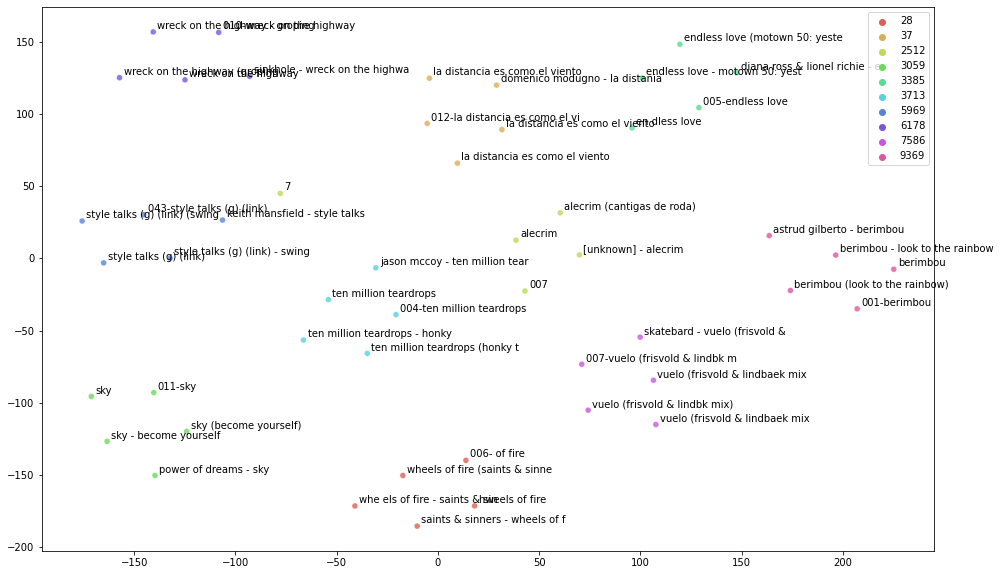

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

plt.figure(figsize=(16,10))
ax = sns.scatterplot(
    x=tsne_results[:,0],
    y=tsne_results[:,1],
    hue=vis_y,
    palette=sns.color_palette("hls", len(vis_cluster_dict.keys())),
    legend="full",
    alpha=0.8
)
for id_, (x, y) in zip(itertools.chain.from_iterable(vis_cluster_dict.values()), tsne_results):
    # text = id_
    text = test_record_dict[id_]['title'][:30]
    ax.text(x + 2, y + 2, text)